# Einfacher Referenztrajektoriengenerator auf Basis einer polynomialen Prototypenfunktion

**(2. Übung Flachheit, Aufgabe 1)**

## Aufgabenstellung

Realisiert werden soll der Übergang von $y$ von einem Wert $y_\mathrm{start}$ auf einen Wert $y_\mathrm{end}$ innerhalb des Intervalls $t_\mathrm{end} - t_\mathrm{start}$ entlang einer Referenztrajektorie $t \mapsto y_{ref}(t)$:

\begin{equation*}
y_\mathrm{ref}(t) =  
\begin{cases}
y_\mathrm{start} &\text{wenn} \; t < t_\mathrm{start}\\
y_\mathrm{start} + (y_\mathrm{end} - y_\mathrm{start}) \varphi_\gamma \left(\frac{t - t_\mathrm{start}}{t_\mathrm{end} - t_\mathrm{start}}\right) &\text{wenn} \; t_\mathrm{start} \leq t \leq t_\mathrm{end}\\
y_\mathrm{end} &\text{wenn} \; t > t_\mathrm{end}
\end{cases}
\end{equation*}
wobei für die $\gamma$ mal stetig differenzierbare Funktion $\varphi_\gamma(\tau)$ gilt mit $\alpha = (2 \gamma + 1)!$:

\begin{equation*}
\varphi_\gamma(\tau) = \frac{\alpha}{(\gamma!)^2} \sum \limits_{k=0}^\gamma \binom{\gamma}{k} \frac{(-1)^k}{\gamma + k + 1} t^{\gamma + k +1}
\end{equation*}

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/flavert-nbviewer-content

**Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!**

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>


---

## Import der nötigen Module

In [1]:
import numpy as np
import scipy.special as scs
import matplotlib.pyplot as plt

## Implementierung der Klasse (unter Nutzung von numpy-Methoden)

### Generelles

- Das erforderliche Polynom wird über die NumPy-Klasse `Polynomial` aus dem `polynomials`-Modul realisiert, um sich nicht mit dessen Implementierung befassen zu müssen. Man handelt sich dann natürlich einen gewissen Overhead ein

- Die *eval*-Methode wird einen Spaltenvektor mit $\gamma+1$-Einträgen zurückliefern. Die $i$.te Zeile enthält die $i$.te-Ableitung der Referenztrajektorie zum Zeitpunkt $t$. Beachten: Python-Arrays sind null-indiziert.

- Die *eval_v* Methode liefert eine Matrix mit $\gamma+1$ Zeilen und so vielen Spalten zurück, wie der übergebene Zeitvektor $t$ Elemente enthält. Die $i$te Zeile enthält also den Verlauf der $i$ten Ableitung für den vorgegebenen Zeitverlauf in $t$.

- Man sollte Arrays nach Möglichkeit vorher initialisieren, wenn die Größe bekannt ist. Dieser Ansatz wird hier verfolgt. Die Nutzung von `append(value)` (Matlab: `x[end+1] = value`) ist ineffektiv. `for`-Schleifen lassen sich auch häufig durch Vektorisierung (oder [list-comprehensions](https://www.w3schools.com/python/python_lists_comprehension.asp)) umgehen.

### Konstruktor
Im Konstruktor erfolgen die nötigen Initialisierungen. Für $t < t_\mathrm{start}$ und $t > t_\mathrm{end}$ ist steht bereits fest, welche Vektoren bzw. Matrizen die *eval* bzw. *eval_v* Methoden zurückliefern. Also werden sie hier bereits festgelegt. Der Polynomübergang wird mittels der *Polynomials* Klasse des *numpy.polynomial*-Moduls realisiert. Im Gegensatz zur Formel oben werden der Offset $y_\mathrm{start}$ und die Skalierung $y_\mathrm{end} - y_\mathrm{start}$ bereits in die Koeffifzienten mit eingerechnet. Die korrekte Skalierung des Funktionsarguments $\frac{t - t_\mathrm{start}}{t_\mathrm{end} - t_\mathrm{start}}$ erfolgt über die kwargs *domain* und *window*. Für die Funktion und die $\gamma$ Ableitungen wird je ein Polynomobjekt abgespeichert.

### *eval*-Methode (Argument *t* ist skalar)
Es wird geprüft, in welchem Zeitabschnitt sich $t$ befindet und davon abhängig die korrekte Rückgabe berechnet. Für die stationären Bereiche kann einfach auf die im Konstruktor bereits berechneten Vektoren zurückgegriffen werden.

### *eval_v*-Methode (Argument *t* ist array_like)
Die zurückzugebende Matrix (für jeden Zeitpunkt eine Spalte mit den Werten der Funktion und der ersten $\gamma$-Ableitungen) wird zunächst als Nullmatrix initialisiert. Anschließend erfolgt das Auffüllen der stationären Anfangs- und Endabschnitte. Abschließend erfolgt im Mittelteil die Polynomauswertung. Hierzu müssen die Indizes der Werte in $t$ bestimmt werden, auf denen der Übergang erfolgt. Die Indizes werden verwendet, um die nötigen Zeitwerte aus $t$ zu extrahieren bzw. den Spaltenbereich in der zurückzugebenden Matrix zu adressieren.

### Hinweise
- Eine vollständig manuelle Implementierung (unter Nutzung des Horner Schemas, ohne Polynomial-Klasse aus numpy) finden Sie zur Lösung von Aufgabe 3.
- Für Python-Profis: Auf (eigentlich sinnvolle) Type-Annotation wurde hier verzichtet, um die Übersichtlichkeit für Anfänger zu wahren, ebenso sind die Docstrings eingedampft

In [2]:
class TrajGenProto:
    """ Trajektoriengenerator auf Basis einer Phototypesetting

    Realisiert einen Übergang von y_start nach y_end auf dem Zeitintervall
    t_end - t_start. Die zugehörige Funktion ist smooth_to mal stetig 
    differenzierbar.
    """

    def __init__(self, t_start, t_end, y_start, y_end, smooth_to):

        # Start- und Endzeiten merken
        self._t0 = t_start
        self._t1 = t_end

        # Die Rückgabe der eval-Funktion für t < t_start steht jetzt schon fest,
        # also gleich abspeichern
        self._y0_vec = np.zeros((smooth_to + 1, 1))
        self._y0_vec[0, 0] = y_start

        # Die Rückgabe der eval-Funktion für t > t_start steht jetzt schon fest,
        # also gleich abspeichern
        self._y1_vec = np.zeros((smooth_to + 1, 1))
        self._y1_vec[0, 0] = y_end

        # Die höchste zu berechnende Ableitung, diese ist auch glatt
        self._gamma = smooth_to

        # Polynome für Berechnung des Übergangs und der Ableitungen aufsetzen
        self._Polys = self.setup_polys(t_start, t_end, y_start, y_end, smooth_to)

    @staticmethod
    def setup_polys(t0, t1, y0, y1, gamma):
        """ Hilfsmethode zum Bestimmen der Polynome.

        Übergang von y0 auf y1 im Intervall t1 - t0, gamma mal stetig diffbar

        Returns:
            Liste mit gamma+1 Objekten vom Typ numpy.polynomials.Polynomial.
            Das i.te Element enthält das Polynom zur Beschreibung
            der i.ten Ableitung.
        """

        # Hilfsgrößen (siehe Formel)
        alpha = scs.factorial(2 * gamma + 1)
        alpha_gamma = alpha / (scs.factorial(gamma)**2)
        delta_y = y1 - y0

        # Koeffizientenvektor (die Verschiebung und Skalierung auf y nehmen wir 
        # hier schon vor, die Koeffizienten 1 bis gamma sind 0!)
        coeffs = np.zeros(2 * gamma + 2)
        coeffs[0] = y0
        for k in range(0, gamma + 1):
            coeffs[gamma + 1 + k] = delta_y * alpha_gamma * scs.binom(gamma, k) * (-1)**k / (gamma + k + 1)

        # Leere Liste für die Funktion und deren gamma Ableitungen bereitstellen
        polys = []

        # Polynom ansetzen, Angaben zu domain und window realisieren -> (t - t0)/(t1 - t0)
        # Siehe https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.html
        polys.append(np.polynomial.Polynomial(coeffs, domain=[t0, t1], window=[0, 1]))

        # Ableitungen
        for i in range(1, gamma + 1):
            polys.append(polys[0].deriv(i))

        return polys

    def eval(self, t):
        """ Wertet die Referenztrajektorie zum Zeitpunkt t aus

        Returns:
            1D numpy.ndarray mit gamma+1 Elementen. Das i.te Element
            enthält die i.te Ableitung der Referenztrajektorie
            zum Zeitpunkt t.
        """
        if t < self._t0:
            return self._y0_vec[:, 0]
        elif t > self._t1:
            return self._y1_vec[:, 0]
        else:
            y_vec = np.zeros(self._gamma + 1)
            for i in range(0, self._gamma + 1):
                y_vec[i] = self._Polys[i](t)
            return y_vec

    def eval_v(self, t):
        """ Wertet die Referenztrajektorie für N in t gegebene Zeitpunkte aus

        Returns:
            2D numpy.ndarray mit gamma+1 Zeilen und N Spalten. Die i.te Zeile
            enthält die i.te Ableitung der Referenztrajektorie
            zu den in t definierten Zeitpunkten.
        """
        y_mat = np.zeros((self._gamma + 1, t.size))

        # Alles für t < t0
        y_mat[:, t < self._t0] = self._y0_vec

        # Alles für t > t1
        y_mat[:, t > self._t1] = self._y1_vec

        # Indizes in t (= Spalten in y_mat) und Zeitwerte für den Polynomübergang
        inds_for_polys = (t >= self._t0) & (t <= self._t1)
        t_for_polys = t[inds_for_polys]

        # Alternative: Obige beide Zeilen als "Python-Magic" :-)
        # inds_for_polys, t_for_polys = list(zip(*[(index, value) for index, value in enumerate(t)
        #                                          if (value >= self._t0) and (value <= self._t1)]))

        # Auswertung Polynomabschnitt
        for i in range(0, self._gamma + 1):
            y_mat[i, inds_for_polys] = self._Polys[i](np.array(t_for_polys))

        return y_mat

## Test der eval-Methode

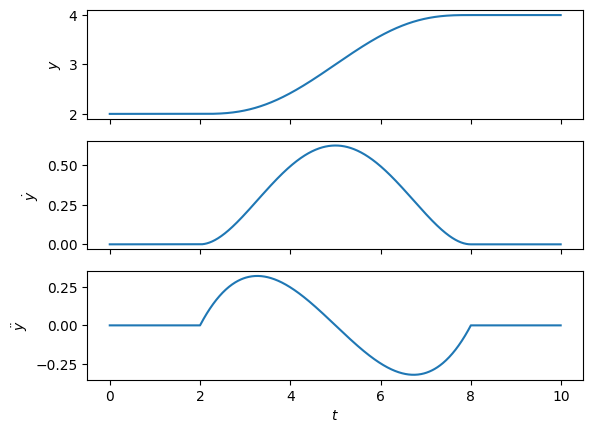

In [3]:
def plot_t_y(t, y):
    fig, ax = plt.subplots(3, 1, sharex=True)

    ax[0].plot(t, y[0, :])
    ax[0].set_ylabel("$y$")

    ax[1].plot(t, y[1, :])
    ax[1].set_ylabel("$\\dot y$")

    ax[2].plot(t, y[2, :])
    ax[2].set_ylabel("$\\ddot y$")
    ax[2].set_xlabel("$t$")


t = np.arange(0, 10, 0.01)
y = np.zeros([3, t.size])
MyTrajGen = TrajGenProto(2, 8, 2, 4, 2)

for i, t_val in enumerate(t):
    x = MyTrajGen.eval(t_val)
    y[:, i] = MyTrajGen.eval(t_val)

plot_t_y(t, y)

Das sieht erst einmal plausibel aus. Sind die Ableitungen aber wirklich korrekt? Dazu vergleichen wir mit der numerischen Differentiation:

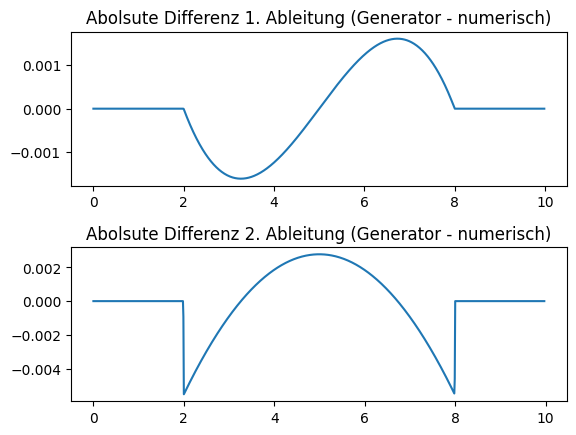

In [4]:
def verify_t_y(t, y):
    ydot_num = np.diff(y[0, :], n=1)/(t[1] - t[0])
    yddot_num = np.diff(y[0, :], n=2)/(t[1] - t[0])**2

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(t[0:-1], y[1, 0:-1] - ydot_num)
    ax[0].set_title("Abolsute Differenz 1. Ableitung (Generator - numerisch)")
    ax[1].plot(t[0:-2], y[2, 0:-2] - yddot_num)
    ax[1].set_title("Abolsute Differenz 2. Ableitung (Generator - numerisch)")
    fig.subplots_adjust(hspace=0.4)


verify_t_y(t, y)

Das sieht auch gut aus. Wenn man die Differenz zwischen jeweils zwei Zeitpunkten in der Zelle oben reduziert, wird die Differenz hier noch kleiner, was auch auf eine korrekte Implementierung hindeutet.

## Test der eval_v-Methode

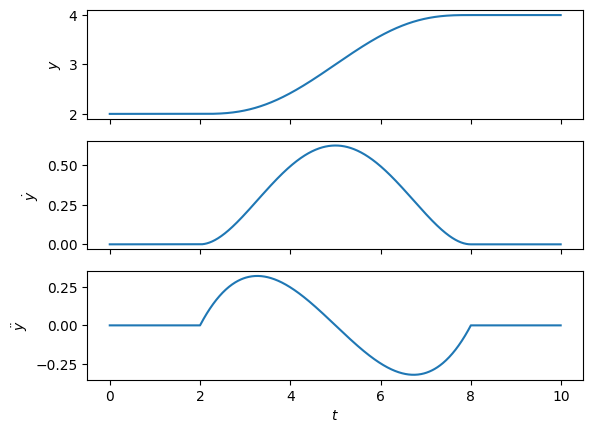

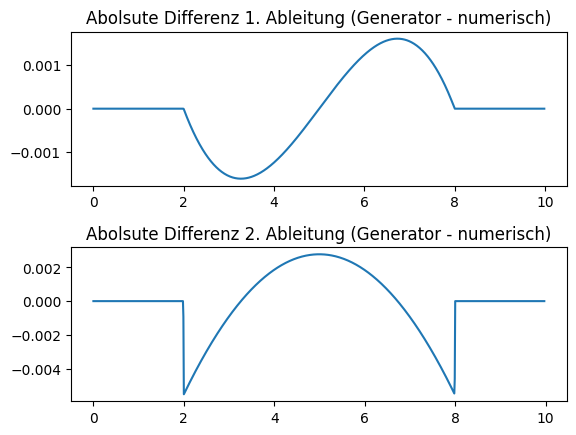

In [5]:
y = MyTrajGen.eval_v(t)
plot_t_y(t, y)
verify_t_y(t, y)